<a href="https://colab.research.google.com/github/SantiagoGomezfpv/hyperparameter/blob/main/pytorchModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón multicapa

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Cargar y preparar datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definir la red neuronal fully connected
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Crear modelo y optimizador
model = FullyConnectedNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Entrenar el modelo
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

# Evaluar el modelo
with torch.no_grad():
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Precisión del modelo en el conjunto de test: %d %%' % (100 * correct / total))


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 33858455.14it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 917722.46it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:49<00:00, 33398.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3823104.31it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[1,   200] loss: 0.663
[1,   400] loss: 0.318
[1,   600] loss: 0.269
[1,   800] loss: 0.242
[2,   200] loss: 0.181
[2,   400] loss: 0.166
[2,   600] loss: 0.149
[2,   800] loss: 0.155
[3,   200] loss: 0.111
[3,   400] loss: 0.121
[3,   600] loss: 0.105
[3,   800] loss: 0.107
[4,   200] loss: 0.080
[4,   400] loss: 0.083
[4,   600] loss: 0.086
[4,   800] loss: 0.086
[5,   200] loss: 0.063
[5,   400] loss: 0.066
[5,   600] loss: 0.068
[5,   800] loss: 0.062
[6,   200] loss: 0.052
[6,   400] loss: 0.053
[6,   600] loss: 0.050
[6,   800] loss: 0.054
[7,   200] loss: 0.042
[7,   400] loss: 0.044
[7,   600] loss: 0.041
[7,   800] loss: 0.042
[8,   200] loss: 0.035
[8,   400] loss: 0.031
[8,   600] loss: 0.033
[8,   800] loss: 0.036
[9,   200] loss: 0.028
[9,   400] loss: 0.026
[9,   600] loss: 0.029
[9,   800] loss: 0.035
[10,   200] loss: 0.025
[10,   400] loss: 0.023
[10,   600] loss: 0.023
[10,   800] loss: 0.025
P

# Optuna Perceptrón multicapa

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00


In [2]:
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Cargar el conjunto de datos MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar los valores de píxeles
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Dividir el conjunto de datos de entrenamiento en entrenamiento y validación
trainset, valset = torch.utils.data.random_split(trainset, [54000, 6000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_units_list, output_size):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size

        for hidden_units in hidden_units_list:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            in_features = hidden_units

        layers.append(nn.Linear(in_features, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def objective(trial):
    hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
    hidden_units_list = [trial.suggest_int(f'hidden_units_{i}', 32, 256) for i in range(hidden_layers)]

    model = MLP(28*28, hidden_units_list, 10).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(5):
        for images, labels in trainloader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18008964.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 492858.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4532416.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4793791.84it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



[I 2024-05-28 12:45:23,385] A new study created in memory with name: no-name-39590738-e26c-4df3-9707-777fb1290aea
[I 2024-05-28 12:46:28,139] Trial 0 finished with value: 0.968 and parameters: {'hidden_layers': 3, 'hidden_units_0': 169, 'hidden_units_1': 123, 'hidden_units_2': 63}. Best is trial 0 with value: 0.968.
[I 2024-05-28 12:47:34,758] Trial 1 finished with value: 0.9718333333333333 and parameters: {'hidden_layers': 3, 'hidden_units_0': 148, 'hidden_units_1': 150, 'hidden_units_2': 203}. Best is trial 1 with value: 0.9718333333333333.
[I 2024-05-28 12:48:39,221] Trial 2 finished with value: 0.9675 and parameters: {'hidden_layers': 3, 'hidden_units_0': 239, 'hidden_units_1': 145, 'hidden_units_2': 226}. Best is trial 1 with value: 0.9718333333333333.
[I 2024-05-28 12:49:42,436] Trial 3 finished with value: 0.9598333333333333 and parameters: {'hidden_layers': 2, 'hidden_units_0': 101, 'hidden_units_1': 198}. Best is trial 1 with value: 0.9718333333333333.
[I 2024-05-28 12:50:46,0

Number of finished trials:  50
Best trial:
  Value:  0.9735
  Params: 
    hidden_layers: 2
    hidden_units_0: 244
    hidden_units_1: 135


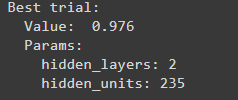

In [3]:
import matplotlib.pyplot as plt
best_params = study.best_params

optuna.visualization.plot_optimization_history(study)

In [4]:
optuna.visualization.plot_parallel_coordinate(study)

In [10]:
optuna.visualization.plot_param_importances(study)

# Modelo CNN



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Definir la arquitectura de la CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*5*5, 128)  # Corregido el tamaño de entrada
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# Cargar los datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [54000, 6000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Instanciar el modelo y definir la función de pérdida y el optimizador
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

# Evaluación del modelo
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the 10000 test images: %d %%' % (
    100 * correct / total))


[1,   100] loss: 0.693
[1,   200] loss: 0.179
[1,   300] loss: 0.120
[1,   400] loss: 0.108
[1,   500] loss: 0.094
[1,   600] loss: 0.087
[1,   700] loss: 0.071
[1,   800] loss: 0.061
[1,   900] loss: 0.062
[2,   100] loss: 0.062
[2,   200] loss: 0.047
[2,   300] loss: 0.045
[2,   400] loss: 0.057
[2,   500] loss: 0.044
[2,   600] loss: 0.049
[2,   700] loss: 0.040
[2,   800] loss: 0.040
[2,   900] loss: 0.041
[3,   100] loss: 0.032
[3,   200] loss: 0.030
[3,   300] loss: 0.028
[3,   400] loss: 0.035
[3,   500] loss: 0.030
[3,   600] loss: 0.027
[3,   700] loss: 0.029
[3,   800] loss: 0.035
[3,   900] loss: 0.031
[4,   100] loss: 0.024
[4,   200] loss: 0.021
[4,   300] loss: 0.018
[4,   400] loss: 0.024
[4,   500] loss: 0.021
[4,   600] loss: 0.027
[4,   700] loss: 0.021
[4,   800] loss: 0.033
[4,   900] loss: 0.026
[5,   100] loss: 0.017
[5,   200] loss: 0.018
[5,   300] loss: 0.015
[5,   400] loss: 0.019
[5,   500] loss: 0.025
[5,   600] loss: 0.023
[5,   700] loss: 0.012
[5,   800] 

# Optuna CNN

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import optuna

# Definir el dispositivo como CUDA si está disponible, de lo contrario usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definición de la CNN
class Net(nn.Module):
    def __init__(self, trial):
        tamano = 28
        super(Net, self).__init__()
        # Definir la arquitectura de la red basada en los hiperparámetros sugeridos
        num_conv_layers = trial.suggest_int("num_conv_layers", 2, 3)
        num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
                       for i in range(num_conv_layers)]
        num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)
        drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)
        drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.5)

        # Capas convolucionales
        self.convs = nn.ModuleList()
        in_channels = 1  # MNIST tiene imágenes en escala de grises, por lo tanto, 1 canal de entrada
        for out_channels in num_filters:
            tamano = tamano-3+2+1  # 3 es el tamaño del Kernel; 2 es dos veces padding
            tamano = int(tamano/2)
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.convs.append(nn.ReLU())
            self.convs.append(nn.MaxPool2d(2))
            in_channels = out_channels
            if len(self.convs) == 4:  # Aplicar dropout después de la segunda capa convolucional
                self.convs.append(nn.Dropout(drop_conv2))

        # Capa completamente conectada
        self.fc1 = nn.Linear(num_filters[-1] * tamano * tamano, num_neurons)
        self.drop_fc1 = nn.Dropout(drop_fc1)
        self.fc2 = nn.Linear(num_neurons, 10)  # 10 clases en MNIST

    def forward(self, x):
        for layer in self.convs:
            x = layer(x)
        x = x.view(x.size(0), -1)  # Aplanar las características para la capa completamente conectada
        x = F.relu(self.fc1(x))
        x = self.drop_fc1(x)
        x = self.fc2(x)
        return x

# Función objetivo para Optuna
def objective(trial):
    # Cargar datos de MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    # Construir la red neuronal
    model = Net(trial).to(device)

    # Optimizar el tipo de optimizador y la tasa de aprendizaje
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Entrenamiento de la red
    model.train()
    for epoch in range(2):  # limitamos a 2 épocas para el ejemplo
        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

    # Validación de la red
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in valloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    return accuracy

# Crear un estudio de Optuna y encontrar los mejores hiperparámetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)


[I 2024-05-14 22:43:16,094] A new study created in memory with name: no-name-a0f48882-4159-4508-8ac5-52b5bc7b77ea
<ipython-input-11-f8a144cb9353>:19: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
<ipython-input-11-f8a144cb9353>:21: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)
<ipython-input-11-f8a144cb9353>:67: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-05-14 22:44:01,209] Trial 0 fin

Mejores hiperparámetros: {'num_conv_layers': 2, 'num_filter_0': 64.0, 'num_filter_1': 80.0, 'num_neurons': 370, 'drop_conv2': 0.35625255760573926, 'drop_fc1': 0.22786095132832312, 'optimizer': 'Adam', 'lr': 0.0012065810008056934}


In [ ]:
best_params = study.best_params

In [ ]:
import matplotlib.pyplot as plt

optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study, params=['num_conv_layers', 'num_filter_0', 'num_filter_1', 'num_neurons', 'drop_conv2', 'drop_fc1', 'optimizer', 'lr'])

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
import torch                                        # Librería para aprendizaje profundo
import torch.nn as nn                               # Contiene módulos para construir redes neuronales
import torch.optim as optim                         # Contiene optimizadores para entrenar redes neuronales
import torchvision                                  # Librería para datasets y transformaciones de visión computacional
import torchvision.transforms as transforms         # Contiene funciones para preprocesar imágenes
import optuna                                       # Librería para optimización hiperparámetros

# Define la arquitectura de la CNN (Red Neuronal Convolucional)
class CNN(nn.Module):
    def __init__(self, trial):
        super(CNN, self).__init__()
        # Capa de convolución 1 con número de filtros variable
        self.conv1 = nn.Conv2d(1, trial.suggest_int('n_filters1', 16, 64), kernel_size=3, stride=1)
        # Capa de convolución 2 con número de filtros variable, dependiendo de la salida de la capa anterior
        self.conv2 = nn.Conv2d(trial.suggest_int('n_filters1', 16, 64), trial.suggest_int('n_filters2', 32, 128), kernel_size=3, stride=1)
        # Capa totalmente conectada (fully connected) con número de unidades variable
        self.fc1 = nn.Linear(trial.suggest_int('n_filters2', 32, 128) * 5 * 5, trial.suggest_int('n_units', 64, 256))
        # Capa de salida con 10 unidades para clasificar en las 10 clases de MNIST
        self.fc2 = nn.Linear(trial.suggest_int('n_units', 64, 256), 10)

    def forward(self, x):
        # Operaciones en la propagación hacia adelante
        x = self.conv1(x)
        x = torch.relu(x)  # Función de activación ReLU (introducir no linealidades en los datos)
        x = torch.max_pool2d(x, 2)  # Max pooling con tamaño de kernel 2x2
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)  # Aplanar la salida para la capa totalmente conectada
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# Cargar el conjunto de datos MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar los valores de píxeles
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Dividir el conjunto de datos de entrenamiento en entrenamiento y validación
trainset, valset = torch.utils.data.random_split(trainset, [54000, 6000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Definir la función objetivo para Optuna
def objective(trial):
  n_estima

    model = CNN(trial)
    criterion = nn.CrossEntropyLoss()  # Función de pérdida para problemas de clasificación
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float('lr', 1e-5, 1e-1, log=True))  # Optimizador Adam con tasa de aprendizaje variable
    num_epochs = 5

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()               # Reiniciar los gradientes acumulados
            outputs = model(inputs)             # Propagación hacia adelante
            loss = criterion(outputs, labels)   # Calcular la pérdida
            loss.backward()                     # Retropropagación
            optimizer.step()                    # Actualización de los pesos

            running_loss += loss.item()

    # Evaluación del modelo en el conjunto de validación
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Obtener las predicciones
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Ejecutar la optimización de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Número de pruebas finalizadas:', len(study.trials))
print('Mejor prueba:')
trial = study.best_trial
print('  Valor: {}'.format(trial.value))
print('  Parámetros: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Optimizador Optuna Elena

[Optuna-optimization-for-PyTorch-CNN](https://github.com/elena-ecn/optuna-optimization-for-PyTorch-CNN/blob/main/optuna_optimization.py#L179)

El conjunto de datos MNIST contiene **60.000** imágenes de **entrenamiento** y **10.000** imágenes de **prueba**.
donde cada muestra es una imagen pequeña, cuadrada, en escala de grises de **28 × 28** píxeles de
dígitos únicos escritos a mano entre 0 y 9.

Los hiperparámetros de CNN elegidos para optimizar son:


*   Tipo de optimizador
*   Tasa de aprendizaje
*   Valores de abandono
*   Número de capas convolucionales
*   Número de filtros de capas convolucionales
*   Número de neuronas de capas completamente conectadas.



In [ ]:
!pip install optuna

In [ ]:
import os                               # Importa el módulo os para interactuar con el sistema operativo
import torch                            # Importa PyTorch
import torchvision                      # Importa torchvision para trabajar con conjuntos de datos y modelos preentrenados
import torch.nn as nn                   # Importa el módulo nn (neural network) de PyTorch para definir redes neuronales
import torch.nn.functional as F         # Importa funciones de activación y pérdida de PyTorch
import torch.optim as optim             # Importa optimizadores de PyTorch
import optuna                           # Importa Optuna para la optimización de hiperparámetros
from optuna.trial import TrialState     # Importa TrialState para el estado de las pruebas en Optuna

In [ ]:
class Net(nn.Module):
    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_fc1):
        """
        Parámetros:
            - trial (optuna.trial._trial.Trial): Prueba de Optuna
            - num_conv_layers (int):             Número de capas convolucionales
            - num_filters (list):                Número de filtros de las capas convolucionales
            - num_neurons (int):                 Número de neuronas de las capas totalmente conectadas
            - drop_conv2 (float):                Ratio de dropout para la capa convolucional 2
            - drop_fc1 (float):                  Ratio de dropout para FC1
        """
        super(Net, self).__init__()                                                     # Inicializa la clase padre
        in_size = 28                                                                    # Tamaño de la imagen de entrada (28 píxeles)
        kernel_size = 3                                                                 # Tamaño del filtro de convolución

        # Define las capas convolucionales
        self.convs = nn.ModuleList([nn.Conv2d(1, num_filters[0], kernel_size=(3, 3))])  # Lista con las capas convolucionales
        out_size = in_size - kernel_size + 1                                            # Tamaño del kernel de salida
        out_size = int(out_size / 2)                                                    # Tamaño después del max-pooling
        for i in range(1, num_conv_layers):
            self.convs.append(nn.Conv2d(in_channels=num_filters[i-1], out_channels=num_filters[i], kernel_size=(3, 3)))
            out_size = out_size - kernel_size + 1                                       # Tamaño del kernel de salida
            out_size = int(out_size/2)                                                  # Tamaño después del max-pooling

        self.conv2_drop = nn.Dropout2d(p=drop_conv2)                                    # Dropout para conv2
        self.out_feature = num_filters[num_conv_layers-1] * out_size * out_size         # Tamaño de las características aplanadas
        self.fc1 = nn.Linear(self.out_feature, num_neurons)                             # Capa totalmente conectada 1
        self.fc2 = nn.Linear(num_neurons, 10)                                           # Capa totalmente conectada 2
        self.p1 = drop_fc1                                                              # Ratio de dropout para FC1

        # Inicializa los pesos con la inicialización de He
        for i in range(1, num_conv_layers):
            nn.init.kaiming_normal_(self.convs[i].weight, nonlinearity='relu')
            if self.convs[i].bias is not None:
                nn.init.constant_(self.convs[i].bias, 0)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')

    def forward(self, x):
        """Propagación hacia adelante.

        Parámetros:
            - x (torch.Tensor): Tensor de entrada de tamaño [N,1,28,28]
        Devuelve:
            - (torch.Tensor): El tensor de salida después de la propagación hacia adelante [N,10]
        """
        for i, conv_i in enumerate(self.convs):  # Para cada capa convolucional
            if i == 2:  # Añade dropout si es la capa 2
                x = F.relu(F.max_pool2d(self.conv2_drop(conv_i(x)), 2))  # Conv_i, dropout, max-pooling, RelU
            else:
                x = F.relu(F.max_pool2d(conv_i(x), 2))                   # Conv_i, max-pooling, RelU

        x = x.view(-1, self.out_feature)                                 # Aplana el tensor
        x = F.relu(self.fc1(x))                                          # FC1, RelU
        x = F.dropout(x, p=self.p1, training=self.training)              # Aplica dropout después de FC1 solo durante el entrenamiento
        x = self.fc2(x)                                                  # FC2

        return F.log_softmax(x, dim=1)                                   # log(softmax(x))


In [ ]:
def train(network, optimizer):
    """
    Entrena el modelo.

    Parámetros:
        - red (__main__.Net):                      La CNN
        - optimizador (torch.optim.<optimizador>): El optimizador para la CNN
    """
    network.train()  # Establece el módulo en modo de entrenamiento (afecta solo ciertos módulos)
    for batch_i, (data, target) in enumerate(train_loader):  # Para cada lote

        # Limita los datos de entrenamiento para una computación más rápida
        if batch_i * batch_size_train > number_of_train_examples:
            break

        optimizer.zero_grad()                                 # Borra los gradientes
        output = network(data.to(device))                     # Propagación hacia adelante
        loss = F.nll_loss(output, target.to(device))          # Calcula la pérdida (negative log likelihood: −log(y))
        loss.backward()                                       # Calcula los gradientes
        optimizer.step()                                      # Actualiza los pesos


In [ ]:
def test(network):
    """
    Evalúa el modelo.

    Parámetros:
        - red (__main__.Net): La CNN

    Devuelve:
        - accuracy_test (torch.Tensor): La precisión de la prueba
    """
    network.eval()         # Establece el módulo en modo de evaluación (afecta solo ciertos módulos)
    correct = 0
    with torch.no_grad():  # Deshabilita el cálculo de gradientes (cuando estás seguro de que no llamarás a Tensor.backward())
        for batch_i, (data, target) in enumerate(test_loader):  # Para cada lote

            # Limita los datos de prueba para una computación más rápida
            if batch_i * batch_size_test > number_of_test_examples:
                break

            output = network(data.to(device))                                     # Propagación hacia adelante
            pred = output.data.max(1, keepdim=True)[1]                            # Encuentra el valor máximo en cada fila, devuelve los índices de los valores máximos
            correct += pred.eq(target.to(device).data.view_as(pred)).sum()        # Calcula las predicciones correctas

    accuracy_test = correct / len(test_loader.dataset)

    return accuracy_test


In [ ]:
def objective(trial):
    """Función objetivo a ser optimizada por Optuna.

    Hiperparámetros elegidos para ser optimizados: optimizador, tasa de aprendizaje,
    valores de dropout, número de capas convolucionales, número de filtros de las
    capas convolucionales, número de neuronas de las capas totalmente conectadas.

    Entradas:
        - trial (optuna.trial._trial.Trial): Prueba de Optuna
    Devuelve:
        - accuracy (torch.Tensor): La precisión de la prueba. Parámetro a maximizar.
    """

    # Define el rango de valores a probar para los hiperparámetros
    num_conv_layers = trial.suggest_int("num_conv_layers", 2, 3)  # Número de capas convolucionales
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
                   for i in range(num_conv_layers)]               # Número de filtros para las capas convolucionales
    num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)   # Número de neuronas de la capa FC1
    drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)      # Dropout para la capa convolucional 2
    drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.5)          # Dropout para la capa FC1

    # Genera el modelo
    model = Net(trial, num_conv_layers, num_filters, num_neurons, drop_conv2,  drop_fc1).to(device)

    # Genera los optimizadores
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])  # Optimizadores
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)                                 # Tasas de aprendizaje
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Entrenamiento del modelo
    for epoch in range(n_epochs):
        train(model, optimizer)  # Entrena el modelo
        accuracy = test(model)   # Evalúa el modelo

        # Para la poda (detiene la prueba temprano si no es prometedora)
        trial.report(accuracy, epoch)
        # Maneja la poda basada en el valor intermedio.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
if __name__ == '__main__':

    # -------------------------------------------------------------------------
    # Estudio de optimización para una CNN de PyTorch con Optuna
    # -------------------------------------------------------------------------

    # Usa cuda si está disponible para cálculos más rápidos
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Parámetros ----------------------------------------------------------
    n_epochs = 10                         # Número de épocas de entrenamiento
    batch_size_train = 64                 # Tamaño del lote para datos de entrenamiento
    batch_size_test = 1000                # Tamaño del lote para datos de prueba
    number_of_trials = 100                # Número de pruebas de Optuna
    limit_obs = True                      # Limitar el número de observaciones para cálculos más rápidos

    # *** Nota: Para resultados más precisos, no limite las observaciones.
    #           Sin embargo, si no se limitan, podría llevar mucho tiempo ejecutarlo.
    #           Otra opción es limitar el número de épocas. ***

    if limit_obs:                                          # Limitar el número de observaciones
        number_of_train_examples = 500 * batch_size_train  # Máximas observaciones de entrenamiento
        number_of_test_examples = 5 * batch_size_test      # Máximas observaciones de prueba
    else:
        number_of_train_examples = 60000                   # Máximas observaciones de entrenamiento
        number_of_test_examples = 10000                    # Máximas observaciones de prueba
    # -------------------------------------------------------------------------

    # Hacer que las ejecuciones sean repetibles
    random_seed = 1
    torch.backends.cudnn.enabled = False  # Deshabilitar el uso de algoritmos no deterministas de cuDNN
    torch.manual_seed(random_seed)

    # Crea el directorio 'files', si no existe, para guardar el conjunto de datos
    directory_name = 'files'
    if not os.path.exists(directory_name):
        os.mkdir(directory_name)

    # Descarga el conjunto de datos MNIST al directorio 'files' y normalízalo
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('/files/', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
        batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('/files/', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
        batch_size=batch_size_test, shuffle=True)

    # Crea un estudio de Optuna para maximizar la precisión de prueba
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=number_of_trials)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5444301.23it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160017.98it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:04<00:00, 393172.39it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4292593.23it/s]
[I 2024-05-07 17:09:26,506] A new study created in memory with name: no-name-123ea2a7-cc3a-482b-b37c-b19f3f9d1e36
<ipython-input-7-67589e027cdb>:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
<ipython-input-7-67589e027cdb>:18: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Número de neuronas de la capa FC1


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



[I 2024-05-07 17:27:21,348] Trial 0 finished with value: 0.48919999599456787 and parameters: {'num_conv_layers': 2, 'num_filter_0': 128.0, 'num_filter_1': 128.0, 'num_neurons': 340, 'drop_conv2': 0.21439508970072876, 'drop_fc1': 0.409350471900658, 'optimizer': 'SGD', 'lr': 4.735407160810673e-05}. Best is trial 0 with value: 0.48919999599456787.
[I 2024-05-07 17:37:19,810] Trial 1 finished with value: 0.595300018787384 and parameters: {'num_conv_layers': 2, 'num_filter_0': 112.0, 'num_filter_1': 48.0, 'num_neurons': 360, 'drop_conv2': 0.3637459814288115, 'drop_fc1': 0.36470795939010936, 'optimizer': 'Adam', 'lr': 0.0008584929846386581}. Best is trial 1 with value: 0.595300018787384.
[I 2024-05-07 17:45:10,827] Trial 2 finished with value: 0.5598999857902527 and parameters: {'num_conv_layers': 3, 'num_filter_0': 80.0, 'num_filter_1': 48.0, 'num_filter_2': 112.0, 'num_neurons': 380, 'drop_conv2': 0.29614793864676914, 'drop_fc1': 0.3769548775900181, 'optimizer': 'Adam', 'lr': 1.42057720473

In [ ]:
# -------------------------------------------------------------------------
# Resultados
# -------------------------------------------------------------------------

# Encuentra el número de pruebas podadas y completadas
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Muestra las estadísticas del estudio
print("\nEstadísticas del estudio:")
print("  Número de pruebas finalizadas: ", len(study.trials))
print("  Número de pruebas podadas: ", len(pruned_trials))
print("  Número de pruebas completadas: ", len(complete_trials))

trial = study.best_trial
print("Mejor prueba:")
print("  Valor: ", trial.value)
print("  Parámetros:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Guarda los resultados en un archivo CSV
df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Excluir columnas
df = df.loc[df['state'] == 'COMPLETE']        # Mantener solo los resultados que no se podaron
df = df.drop('state', axis=1)                 # Excluir columna de estado
df = df.sort_values('value')                  # Ordenar según la precisión
df.to_csv('optuna_results.csv', index=False)  # Guardar en archivo CSV

# Muestra los resultados en un DataFrame
print("\nResultados generales (ordenados por precisión):\n {}".format(df))

# Encuentra los hiperparámetros más importantes
most_important_parameters = optuna.importance.get_param_importances(study, target=None)

# Muestra los hiperparámetros más importantes
print('\nHiperparámetros más importantes:')
for key, value in most_important_parameters.items():
    print('  {}:{}{:.2f}%'.format(key, (15-len(key))*' ', value*100))


# PyG (PyTorch Geometric)

[Documentation](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#learning-methods-on-graphs)

In [12]:
# Instalar: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7?permalink_comment_id=3674777

import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 45.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 49.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00


In [13]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Definición de la primera capa de convolución GCN.
        # dataset.num_node_features es el número de características en cada nodo del grafo.
        # La primera capa convolucional transforma estas características en un espacio de características de tamaño 16.
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        # Definición de la segunda capa de convolución GCN.
        # La entrada son 16 características producidas por la capa anterior,
        # y la salida es un vector de características de tamaño igual al número de clases en el dataset.
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        # Se obtienen los datos de entrada: x son las características de los nodos y edge_index es la estructura del grafo.
        x, edge_index = data.x, data.edge_index

        # Paso de la primera capa GCN.
        x = self.conv1(x, edge_index)
        # Aplicación de la función de activación ReLU.
        x = F.relu(x)
        # Aplicación de dropout para regularización.
        x = F.dropout(x, training=self.training)
        # Paso de la segunda capa GCN.
        x = self.conv2(x, edge_index)

        # Se aplica la función de activación log_softmax para obtener la salida del modelo.
        # Esto proporciona la probabilidad de que cada nodo pertenezca a cada clase.
        return F.log_softmax(x, dim=1)


In [ ]:
# Selecciona el dispositivo de cómputo (GPU si está disponible, de lo contrario, CPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instancia el modelo GCN y lo mueve al dispositivo seleccionado.
model = GCN().to(device)
# Mueve los datos de entrada al dispositivo seleccionado.
data = dataset[0].to(device)
# Define el optimizador Adam para actualizar los parámetros del modelo durante el entrenamiento.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Indica que el modelo está en modo de entrenamiento.
model.train()
# Ciclo de entrenamiento que itera sobre un número fijo de épocas (en este caso, 200).
for epoch in range(200):
    # Reinicia los gradientes del optimizador.
    optimizer.zero_grad()
    # Propaga los datos de entrada a través del modelo para obtener las predicciones.
    out = model(data)
    # Calcula la función de pérdida NLL (negative log likelihood) para los nodos de entrenamiento.
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    # Retropropaga el error para calcular los gradientes.
    loss.backward()
    # Actualiza los parámetros del modelo utilizando el optimizador.
    optimizer.step()


In [ ]:
# Indica que el modelo está en modo de evaluación. Esto desactiva capas como Dropout que se usan durante el entrenamiento.
model.eval()
# Realiza predicciones en los datos de prueba y obtiene la clase predicha para cada nodo.
pred = model(data).argmax(dim=1)
# Calcula el número de predicciones correctas comparando las predicciones con las etiquetas verdaderas de los nodos de prueba.
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
# Calcula la precisión dividiendo el número de predicciones correctas entre el número total de nodos de prueba.
acc = int(correct) / int(data.test_mask.sum())
# Imprime la precisión.
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8100


# Optuna Graphs

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.6 MB/s eta 0:00:00


In [22]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

# Cargar el dataset Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_units_list, output_dim):
        super(GCN, self).__init__()
        self.layers = torch.nn.ModuleList()
        in_channels = input_dim

        for hidden_units in hidden_units_list:
            self.layers.append(GCNConv(in_channels, hidden_units))
            in_channels = hidden_units

        self.layers.append(GCNConv(in_channels, output_dim))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv in self.layers[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

def objective(trial):
    hidden_layers = trial.suggest_int('hidden_layers', 1, 5)
    hidden_units_list = [trial.suggest_int(f'hidden_units_{i}', 16, 256) for i in range(hidden_layers)]

    model = GCN(dataset.num_node_features, hidden_units_list, dataset.num_classes).to(device)
    data = dataset[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=300)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-05-28 13:51:10,367] A new study created in memory with name: no-name-ff5b6695-57a0-47b4-9cf7-caeeb446d28a
[I 2024-05-28 13:51:11,929] Trial 0 finished with value: 0.77 and parameters: {'hidden_layers': 5, 'hidden_units_0': 43, 'hidden_units_1': 20, 'hidden_units_2': 124, 'hidden_units_3': 35, 'hidden_units_4': 86}. Best is trial 0 with value: 0.77.
[I 2024-05-28 13:51:12,851] Trial 1 finished with value: 0.792 and parameters: {'hidden_layers': 2, 'hidden_units_0': 135, 'hidden_units_1': 80}. Best is trial 1 with value: 0.792.
[I 2024-05-28 13:51:13,543] Trial 2 finished with value: 0.793 and parameters: {'hidden_layers': 1, 'hidden_units_0': 32}. Best is trial 2 with value: 0.793.
[I 2024-05-28 13:51:15,197] Trial 3 finished with value: 0.747 and parameters: {'hidden_layers': 4, 'hidden_units_0': 209, 'hidden_units_1': 204, 'hidden_units_2': 201, 'hidden_units_3': 140}. Best is trial 2 with value: 0.793.
[I 2024-05-28 13:51:17,107] Trial 4 finished with value: 0.785 and paramet

Number of finished trials:  300
Best trial:
  Value:  0.824
  Params: 
    hidden_layers: 2
    hidden_units_0: 169
    hidden_units_1: 229


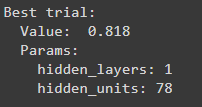

In [23]:
import matplotlib.pyplot as plt
best_params = study.best_params

optuna.visualization.plot_optimization_history(study)

In [24]:
optuna.visualization.plot_parallel_coordinate(study)

In [25]:
optuna.visualization.plot_param_importances(study)